GraphProgramBench
=======

## Context

HybridAGI uses an innovative yet simple **Domain Specific Language** for its intern functioning, **derived from Cypher**. Its natural language-close vocabulary allows users to **intuitively design programs for rule-based AI behavior control**, allowing powerful planification, flexibility and at the end of the day endless possibilities. One purpose of using a simple DSL for programming AI agents is to give the agent the capacity to **easily program itself**, granting it autonomy in figuring out a path to follow in order to carry out a given task.\
However, **since our DSL draws inspiration from Cypher, LLMs tend to confuse them both** as the data they’ve been trained on didn’t include the former.

## Objectives

HybridAGI heavily relies on Large Language Models to power its decision-making within the graph, and therefore depends on the **LLM’s ability to understand the DSL specificities** without considering it simply as Cypher programming. For this matter, one needs to **fine-tune the LLM** to reason on programs written using the DSL.\
The objective of this benchmark is to **determine which LLM leverages best the DSL** to select the one to further improve with fine-tuning. The results are expected to depict the qualities of each model in **rigorously following instructions and deciding judiciously** on a selection of tasks covering various use cases.

====================

In the following code, we declare the models to use for benchmarking (running locally through ollama), then the method to setup HybridAGI before assessing a new case. It starts a new instance of the program memory, trace memory, filesystem, etc and loads the Cyhper programs in the program memory.

In [1]:
LLM_list = ['llama3', 'phi3', 'gemma', 'mistral']
LLM_models = ['llama3_8b', 'phi3_3.8b', 'gemma_7b', 'mistral-7b']

In [2]:
import dspy
import sys
import argparse
import json
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from hybridagi import GraphProgramInterpreter
from hybridagi import SentenceTransformerEmbeddings
from hybridagi import ProgramMemory, TraceMemory, FileSystem, AgentState
from hybridagi.tools import (
    DuckDuckGoSearchTool,
    ProgramSearchTool,
    DocumentSearchTool,
    CallProgramTool,
    PredictTool,
    InternalShellTool,
    WriteFileTool,
    AppendFileTool,
    ReadFileTool,
    SpeakTool,
    AskUserTool,
    UpdateObjectiveTool,
    UploadTool,
    ClearTraceTool,
    PastActionSearchTool,
    #PlannifyProgramTool,
    #ChainOfThoughtTool,
    #ProgramOfThoughtTool,
    ReadProgramTool,
    RevertTraceTool,
    WriteProgramTool,
)
from pydantic import BaseModel
from dspy.teleprompt import BootstrapFewShotWithRandomSearch


class AssessAnswer(dspy.Signature):
    """Assess the success of the trace according to the objective"""
    assessed_answer = dspy.InputField(desc="The answer to assess")
    assessed_question = dspy.InputField(desc="The question to be assessed")
    critique = dspy.OutputField(desc="The critique of the answer")

class Score(BaseModel):
    score: float

class CritiqueToScoreSignature(dspy.Signature):
    """Convert a critique into a score between 0.0 and 1.0"""
    critique = dspy.InputField(desc="The critique to convert into a score")
    score: Score = dspy.OutputField(desc="A score between 0.0 and 1.0")

def case_setup(example_index, embeddings):

    #print("Initializing the program memory...")
    program_memory = ProgramMemory(
        index_name = example_index,
        embeddings = embeddings,
        wipe_on_start = True,
    )

    #print("Initializing the trace memory...")
    trace_memory = TraceMemory(
        index_name = example_index,
        embeddings = embeddings,
        wipe_on_start = True,
    )

    #print("Initializing the internal filesystem...")
    filesystem = FileSystem(
        index_name = example_index,
        embeddings = embeddings,
    )
    
    agent_state = AgentState()

    tools = [
        DuckDuckGoSearchTool(),
        PredictTool(),
        ProgramSearchTool(
            program_memory = program_memory,
            embeddings = embeddings,
        ),
        DocumentSearchTool(
            filesystem = filesystem,
            embeddings = embeddings,
        ),
        CallProgramTool(
            program_memory = program_memory,
            agent_state = agent_state,
        ),
        InternalShellTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        WriteFileTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        AppendFileTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        ReadFileTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        UploadTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        SpeakTool(
            agent_state = agent_state,
        ),
        AskUserTool(
            agent_state = agent_state,
        ),
        UpdateObjectiveTool(
            agent_state=agent_state
        ),
        UploadTool(
            filesystem=filesystem,
            agent_state=agent_state
        ),
        ClearTraceTool(
            agent_state=agent_state
        ),
        PastActionSearchTool(
            trace_memory=trace_memory,
            embeddings=embeddings
        ),
        InternalShellTool(
            filesystem=filesystem,
            agent_state=agent_state
        ),
        ReadProgramTool(
            program_memory=program_memory
        ),
        RevertTraceTool(
            agent_state=agent_state
        ),
        WriteProgramTool(
            program_memory=program_memory
        )
    ]

    program_memory.add_folders(["examples/primitives", "examples/"+example_index+"/programs"])

    interpreter = GraphProgramInterpreter(
                program_memory = program_memory,
                trace_memory = trace_memory,
                agent_state = agent_state,
                tools = tools,
            )
    
    return program_memory, trace_memory, filesystem, agent_state, tools, interpreter

/home/timothee/anaconda3/envs/hybridagi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tasks

The tasks used for benchmarking the LLMs assess their decision-making and ability to properly follow the instructions within the graph described by the program it is prompted with. The tasks include interactions with HybridAGI memory, filesystem, tools, etc along with question answering and retrieval augmented generation.

There are 8 tasks on which the LLM is evaluated :
* **rag_with_optional_websearch** : prompts HybridAGI to answer some questions that may need up-to-date information to retrieve from
* **rag_that_remember_actions** : prompts HybridAGI to answer some questions with checking if a corresponding search has been made in the past and stored in its long-term memory
* **dynamic_call_agent** : prompts HybridAGI with an instruction or a question, and it has to choose among the sub programs stored in its program_memory to produce the answer/task
* **qa_multi_hop_with_critique** : prompts HybridAGI to answer multi-hops questions and auto-assess the answer before producing the final answer
* **rag_with_filesystem** : prompts HybridAGI to answer some questions with information retrieval from relevant files stored in the filesystem
* **rag_that_clarify_question** : prompts HybridAGI to answer some questions after refining the objective by querying the user if it’s unclear in some respects
* **rag_that_take_notes** : prompts HybridAGI to answer some questions by searching the web if needed, and if so to write the answer down to a file for later retrieval
* **qa_simple** : simple question-answering

## Metrics

We make use of DSPy to evaluate the models on the tasks. DSPy allows to use a **customized evaluation function**, and automatically assess the results with regards to this function with a **teacher LLM** (we use Mistral 7B).
Depending on the task nature (instruction/question-answering) the assessor will look up the trace and determine whether the task was achieved or not, and give it a mark (**critique**) between 0 and 1.

====================

The following launchs the evaluation for each LLM. It sets HybridAGI up with each program and use DSPy to perform evaluation on 4 objectives from the example dataset (instructions/questions), as requested through the config variable.

In [3]:
def evaluate_model(model_name, examples, embeddings):
    student_llm = dspy.OllamaLocal(model=model_name, max_tokens=1024, stop=["\n\n\n", "\n\n---\n", "<|eot_id|>"])
    teacher_llm = dspy.OllamaLocal(model='mistral', max_tokens=1024, stop=["\n\n\n", "\n\n---\n", "<|eot_id|>"])

    dspy.settings.configure(lm=student_llm)

    def program_success(example, pred, trace=None):
            question = example.objective
            with dspy.context(lm=teacher_llm):
                prediction = dspy.ChainOfThought(AssessAnswer)(
                    assessed_answer = pred.final_answer,
                    assessed_question = question,
                )
                result = dspy.TypedPredictor(CritiqueToScoreSignature)(critique=prediction.critique)
            return result.score.score
    
    """ optimizer = BootstrapFewShotWithRandomSearch(
        num_threads = 1,
        teacher_settings=dict({'lm': teacher_llm}),
        metric = program_success,
        **config,
    ) """

    scores = []

    for example_index in examples:
        print("EXAMPLE ", example_index)
        program_memory, trace_memory, filesystem, agent_state, tools, interpreter = case_setup(example_index, embeddings)
        with open("examples/"+example_index+"/objectives.json", 'r') as objectives_f:
            objectives = json.load(objectives_f)
        dataset, testset = objectives["dataset"], objectives["testset"]

        """ compiled_interpreter = optimizer.compile(
            interpreter,
            trainset=[dspy.Example(objective).with_inputs("objective") for objective in dataset],
            valset=testset,
        ) """

        evaluate = dspy.evaluate.Evaluate(
            devset = [dspy.Example(objective).with_inputs("objective") for objective in testset],
            metric = program_success,
            num_threads = 1,
            display_progress = False,
            display_table = 0,
        )
        try:
            baseline_score = evaluate(interpreter)
        except Exception:
            baseline_score = 0.0
        
        scores.append(baseline_score)
    
    print(scores)
    print(f"{model_name} achieved average score of {np.mean(scores)}")
    return scores

In [4]:
embeddings = SentenceTransformerEmbeddings(dim=384, model_name_or_path="sentence-transformers/all-MiniLM-L6-v2")

examples = [example for example in os.listdir("examples") if os.path.isdir(os.path.join("examples", example)) and example != 'primitives']

config = dict(max_bootstrapped_demos=4, max_labeled_demos=4)

models_scores = {}

for model_name in tqdm(LLM_list):
    scores = evaluate_model(model_name, examples, embeddings)
    models_scores[model_name] = scores

results = pd.DataFrame(models_scores.values(), columns=examples, index=models_scores.keys())
results["average"] = results.mean(axis=1)
print(results)

/home/timothee/anaconda3/envs/hybridagi/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/timothee/anaconda3/envs/hybridagi/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
  0%|                                                                                                                                                                 | 0/4 [00:00<?, ?it/s]

EXAMPLE  rag_with_optional_websearch
 --- Step 0 ---
Call Program: main
Program Purpose: What is the tallest mountain in the world?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-23 11:30:04,082 ERROR dspy.evaluate.evaluate: 2024-05-23T09:30:04.082301Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=tallest+mountain&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-165163055723468446304774989489989830227&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Who is the richest person in the world currently?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-23 11:30:09,770 ERROR dspy.evaluate.evaluate: 2024-05-23T09:30:09.770876Z [error    ] Error for example in dev set: 		 _text_extract_json() keywords='richest person in world' ValueError: subsection not found [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the formula for calculating the area of a circle?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-23 11:30:21,880 ERROR dspy.evaluate.evaluate: 2024-05-23T09:30:21.879953Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=circle+area+formula&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-97989906584904841795640126548811540330&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the latest news about COVID-19 vaccines?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-23 11:30:29,378 ERROR dspy.evaluate.evaluate: 2024-05-23T09:30:29.377988Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=COVID-19+vaccine+news&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-281780611040454341767299254707569887081&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the chemical formula for water?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: NO
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "H2O"
}
 --- Step 3 ---
End Program: main
Final Answer:

H2O
Chat History:

[
  {
    "role": "User",
    "message": "What is the chemical formula for water?"
  },
  {
    "role": "AI",
    "message": "H2O"
  }
]
EXAMPLE  rag_that_remember_actions
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": "What is blockchain? OR How does blockchain work? OR Blockchain definition",
  "past_actions": []
}
 --- Step 2 ---
Decision Purpose: Check if th

2024-05-23 11:32:43,739 ERROR dspy.evaluate.evaluate: 2024-05-23T09:32:43.739018Z [error    ] Error for example in dev set: 		 Invalid tool: 'ContentSearch' does not exist, should be one of ['DuckDuckGoSearch', 'Predict', 'ProgramSearch', 'DocumentSearch', 'CallProgram', 'InternalShell', 'WriteFile', 'AppendFile', 'ReadFile', 'Upload', 'Speak', 'AskUser', 'UpdateObjective', 'ClearTrace', 'PastActionSearch', 'ReadProgram', 'RevertTrace', 'WriteProgram'] [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 5 ---
Action Purpose: Pick the most appropriate routine from the previous search
Action: {
  "selected_routine": "filesystem_search",
  "observation": "Successfully called"
}
 --- Step 0 ---
Call Program: main
Program Purpose: What is a neuro-symbolic artificial intelligence?


2024-05-23 11:32:46,203 ERROR dspy.primitives.assertions: 2024-05-23T09:32:46.203781Z [error    ] AssertionError: Got OBJECTIVE: WHAT IS A NEURO-SYMBOLIC ARTIFICIAL INTELLIGENCE?.

Selected Label should be only ONE of the following label: QUESTION or INSTRUCTION [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 11:32:46,204 ERROR dspy.evaluate.evaluate: 2024-05-23T09:32:46.204722Z [error    ] Error for example in dev set: 		 Got OBJECTIVE: WHAT IS A NEURO-SYMBOLIC ARTIFICIAL INTELLIGENCE?.

Selected Label should be only ONE of the following label: QUESTION or INSTRUCTION [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Search for HybridAGI on internet
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: QUESTION
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "Hybrid Artificial General Intelligence (HybridAGI) refers to a hypothetical AI system that combines the strengths of different AI approaches, such as rule-based systems, connectionist networks, and symbolic reasoning, to achieve human-like intelligence."
}
 --- Step 3 ---
End Program: main
Final Answer:


Chat History:

[
  {
    "role": "User",
    "message": "Search for HybridAGI on internet"
  },
  {
    "role": "AI",
    "message": ""
  }
]
 --- Step 0 ---
Call Program: main
Program Purpose: Print the current working directory
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Questio

2024-05-23 11:33:37,673 ERROR dspy.evaluate.evaluate: 2024-05-23T09:33:37.673137Z [error    ] Error for example in dev set: 		 Invalid tool: 'ContentSearch' does not exist, should be one of ['DuckDuckGoSearch', 'Predict', 'ProgramSearch', 'DocumentSearch', 'CallProgram', 'InternalShell', 'WriteFile', 'AppendFile', 'ReadFile', 'Upload', 'Speak', 'AskUser', 'UpdateObjective', 'ClearTrace', 'PastActionSearch', 'ReadProgram', 'RevertTrace', 'WriteProgram'] [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 5 ---
Action Purpose: Pick the most appropriate routine from the previous search
Action: {
  "selected_routine": "filesystem_search",
  "observation": "Successfully called"
}
EXAMPLE  qa_multi_hop_with_critique
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "**Benefits:**\n\n1. **Improved accuracy**: AI-powered systems can analyze large amounts of data quickly and accurately, reducing human bias and errors.\n2. **Increased efficiency**: AI can automate routine tasks, freeing up employees to focus on higher-value work.\n3. **Enhanced decision-making**: AI-driven insights can provide organizations with data-driven recommendations for performance evaluation and decision-making.\n4. **Cost savings**: AI-powered systems can reduce the need for manual dat

2024-05-23 11:34:56,184 ERROR dspy.primitives.assertions: 2024-05-23T09:34:56.184176Z [error    ] AssertionError: Got THE SELECTED LABEL IS:.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 11:34:56,185 ERROR dspy.evaluate.evaluate: 2024-05-23T09:34:56.185017Z [error    ] Error for example in dev set: 		 Got THE SELECTED LABEL IS:.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What are some potential industries or professions that could be significantly affected by AI in the coming years? list 5 of them
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "1. **Healthcare Professionals**: AI-powered diagnostic tools and personalized medicine may replace some healthcare professionals' roles, such as radiologists and pathologists.\n2. **Customer Service Representatives**: Chatbots and virtual assistants could automate routine customer inquiries, reducing the need for human representatives in certain industries.\n3. **Financial Analysts**: AI-driven financial modeling and forecasting software might reduce the demand for human analysts in areas like investment banking and portfolio management.\n4. **Manufacturing Line Workers**: Automation and robotics could replace some manufacturing line workers as AI-powered machines take over repetitive tasks, such as assembly and inspection

2024-05-23 11:39:53,796 ERROR dspy.primitives.assertions: 2024-05-23T09:39:53.796117Z [error    ] AssertionError: Got BASED ON MY ANALYSIS, I WOULD SELECT THE OPTION:.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 11:39:53,796 ERROR dspy.evaluate.evaluate: 2024-05-23T09:39:53.796911Z [error    ] Error for example in dev set: 		 Got BASED ON MY ANALYSIS, I WOULD SELECT THE OPTION:.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": "French Revolution date",
  "passages": [
    {
      "long_text": "IlRoZSBGcmVuY2ggUmV2b2x1dGlvbiBvY2N1cnJlZCBiZXR3ZWVuIDE3ODkgYW5kIDE3OTkuIg==",
      "metadata": {
        "filename": "/home/user/french_revolution_date.txt"
      }
    },
    {
      "long_text": "KiogIlRoZSBGcmVuY2ggUmV2b2x1dGlvbiBvY2N1cnJlZCBiZXR3ZWVuIDE3ODkgYW5kIDE3OTkuIg==",
      "metadata": {
        "filename": "/home/user/** french_revolution_date.txt",
        "location": "/home/user/** french_revolution_date.txt"
      }
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- Step 3 ---
Action Purpose: Answer the objective's question based on the document search
Action: {
  "ans

2024-05-23 11:40:43,062 ERROR dspy.primitives.assertions: 2024-05-23T09:40:43.062244Z [error    ] AssertionError: Got I THINK YOU'RE ON THE RIGHT TRACK!.

Selected Label should be only ONE of the following label: NO or YES [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 11:40:43,063 ERROR dspy.evaluate.evaluate: 2024-05-23T09:40:43.063070Z [error    ] Error for example in dev set: 		 Got I THINK YOU'RE ON THE RIGHT TRACK!.

Selected Label should be only ONE of the following label: NO or YES [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  qa_simple
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "**Benefits:**\n\n1. **Improved accuracy**: AI can analyze large amounts of data quickly and accurately, reducing human bias and errors.\n2. **Increased efficiency**: AI can automate routine tasks, freeing up employees to focus on higher-value work.\n3. **Enhanced decision-making**: AI can provide insights and recommendations based on data-driven analysis, supporting informed decision-making.\n4. **Faster feedback**: AI can provide immediate feedback and coaching, enabling employees to adjust their performance quickly.\n\n**Risks:**\n\n1. **Job displacement**: AI may automate tasks currently performed by humans, potentially displacing certain jobs.\n2. **Biased decision-making**: AI systems can

 25%|██████████████████████████████████████                                                                                                                  | 1/4 [12:42<38:06, 762.18s/it]

[20.0, 72.0, 35.0, 50.0, 78.0, 60.0, 55.0, 88.0]
llama3 achieved average score of 57.25
EXAMPLE  rag_with_optional_websearch
 --- Step 0 ---
Call Program: main
Program Purpose: What is the tallest mountain in the world?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-23 11:42:55,424 ERROR dspy.evaluate.evaluate: 2024-05-23T09:42:55.424598Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=tallest+mountain%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Objective%3A+Identify+the+tallest+mountain+on+Earth.&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-207633877875369162757493175266272537965&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Who is the richest person in the world currently?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-23 11:43:02,067 ERROR dspy.evaluate.evaluate: 2024-05-23T09:43:02.067220Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=Who+is+the+richest+person+in+the+world+currently%3F+DuckDuckGo&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-142953278547603113011900362172464619341&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the formula for calculating the area of a circle?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-23 11:43:35,209 ERROR dspy.evaluate.evaluate: 2024-05-23T09:43:35.209469Z [error    ] Error for example in dev set: 		 https://duckduckgo.com/ return None. params=None data={'q': 'calculate area of circle formula<|end|><|assistant|> Search Query: circle area calculation formula<|end|><|assistant|> Formula for Circle Area DuckDuckGo Query: area of a circle formula<|end|><|assistant|> Calculating Circle Area DuckDuckGo Query: how to calculate the area of a circle<|end|><|assistant|> Circle Area Formula DuckDuckGo Query: circle area formula<|end|><|assistant|> Search Query: circle area calculation<|end|><|assistant|> Circle Area Formula DuckDuckGo Query: area of a circle formula<|end|><|assistant|> Calculate Circle Area DuckDuckGo Query: how to calculate the area of a circle<|end|><|assistant|> Search Query: calculating circle area<|end|><|assistant|> Circle Area Formula DuckDuckGo Query: circle area formula<|end|><|assistant|> Search Query: circle area calculation formula<|end|><

 --- Step 0 ---
Call Program: main
Program Purpose: What is the latest news about COVID-19 vaccines?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-23 11:43:47,976 ERROR dspy.evaluate.evaluate: 2024-05-23T09:43:47.976743Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=latest+COVID-19+vaccine+updates+2023%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Latest+COVID-19+vaccine+developments&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-323363902382850292681852323783123893433&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the chemical formula for water?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: NO
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The chemical formula for water is H2O."
}
 --- Step 3 ---
End Program: main
Final Answer:

The chemical formula for water is H2O.<|end|><|endoftext|>
Chat History:

[
  {
    "role": "User",
    "message": "What is the chemical formula for water?"
  },
  {
    "role": "AI",
    "message": "The chemical formula for water is H2O.<|end|><|endoftext|>"
  }
]
EXAMPLE  rag_that_remember_actions
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": 

2024-05-23 11:44:24,181 ERROR dspy.evaluate.evaluate: 2024-05-23T09:44:24.181377Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=define+blockchain+technology%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Objective%3A+To+explain+the+concept+of+blockchain+technology.&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-5576370945654825169771880920151409945&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Does the lasagna contains tomatoes?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": "lasagna ingredients containing tomatoes<|end|><|assistant|> Query: lasagna recipe with tomato content<|end|><|assistant|> Query: lasagna preparation and ingredients list checking for tomatoes presence<|end|><|assistant|> Query: whether lasagna has tomatoes in its traditional recipe<|end|><|assistant|> Query: lasagna ingredient search query - tomatoes<|end|><|endoftext|>",
  "past_actions": []
}


2024-05-23 11:44:30,895 ERROR dspy.primitives.assertions: 2024-05-23T09:44:30.895731Z [error    ] AssertionError: Got TOMATOES.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 11:44:30,896 ERROR dspy.evaluate.evaluate: 2024-05-23T09:44:30.896533Z [error    ] Error for example in dev set: 		 Got TOMATOES.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "Date of French Revolution history events<|end|><|assistant|> Query: French Revolution timeline",
    "dates of major events in French Revolution<|end|><|assistant|> Query: French Revolution start date",
    "beginning of the French Revolution<|end|><|assistant|> Query: French Revolution years",
    "timeline of the French Revolution<|end|><|assistant|> Query: French Revolution historical dates",
    "chronology of the French Revolution<|end|><|assistant|> Query: When did the French Revolution begin?",
    "start date of the French Revolution<|end|><|assistant|> Query: French Revolution period",
    "timeframe of the French Revolution<|end|><|assistant|> Query: French Revolution occurrence year",
    "year when the French Revolution took place<|end|><|assistant|> Query: Historical date

2024-05-23 11:45:22,338 ERROR dspy.evaluate.evaluate: 2024-05-23T09:45:22.337969Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=key+features+and+benefits+of+blockchain+technology%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+%7B&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-232396891497860925087871191424169803885&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the recipe of lasagna?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "lasagna recipe",
    "classic lasagna ingredients and steps<|end|><|assistant|> Objective: To find a detailed recipe for making lasagna."
  ],
  "past_actions": []
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- Step 3 ---
Action Purpose: Answer the objective's question based on the search
Action: {
  "message": "Based on our search, here is a detailed recipe for making lasagna. This classic lasagna includes layers of pasta, meat sauce, and cheese baked together to create a delicious dish. Here are the ingredients and steps you'll need:\n\nIngredients:\n- 1 pound ground beef or Italian sausage\n- 1 onion, chopped\n- 2 cloves garlic, minced\n- 8 ounces lasagna noodles

2024-05-23 11:46:53,112 ERROR dspy.primitives.assertions: 2024-05-23T09:46:53.112215Z [error    ] AssertionError: Got BOTH<|END|><|ASSISTANT|> SELECTED LABEL: BOTH<|END|><|ASSISTANT|> OBJECTIVE: TO IDENTIFY KEY RESEARCH AREAS AND CHALLENGES IN NEURO-SYMBOLIC ARTIFICIAL INTELLIGENCE..

Selected Label should be only ONE of the following label: INSTRUCTION or QUESTION [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 11:46:53,113 ERROR dspy.evaluate.evaluate: 2024-05-23T09:46:53.113231Z [error    ] Error for example in dev set: 		 Got BOTH<|END|><|ASSISTANT|> SELECTED LABEL: BOTH<|END|><|ASSISTANT|> OBJECTIVE: TO IDENTIFY KEY RESEARCH AREAS AND CHALLENGES IN NEURO-SYMBOLIC ARTIFICIAL INTELLIGENCE..

Selected Label should be only ONE of the following label: INSTRUCTION or QUESTION [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Search for HybridAGI on internet
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: INSTRUCTION
 --- Step 2 ---
Call Program: fulfill_objective
Program Purpose: Fullfil the objective
 --- Step 3 ---
Action Purpose: Search for existing routine to fulfill the objective
Action: {
  "query": "HybridAGI search query",
  "routines": [
    {
      "routine": "filesystem_search: Perform a similarity based search on the filesystem"
    },
    {
      "routine": "internet_search: Search the answer to the given question on internet"
    },
    {
      "routine": "read_file_to_answer: Read the given document to answer the given question"
    }
  ]
}
 --- Step 4 ---
Decision Purpose: Check if the routine to fulfill the objective is in the previous search
Decision Question: Is the routine to fulfill the objective in the abov

2024-05-23 11:49:18,269 ERROR dspy.evaluate.evaluate: 2024-05-23T09:49:18.269903Z [error    ] Error for example in dev set: 		 ('Too many retries trying to get the correct output format. Try simplifying the requirements.', {'score': "ValueError('json output should start and end with { and }')"}) [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  qa_multi_hop_with_critique
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The use of artificial intelligence (AI) in performance evaluation and decision-making processes presents both risks and benefits for organizations. \n\nBenefits include:\n1. Improved efficiency: AI can automate repetitive tasks, allowing employees to focus on more complex responsibilities. This leads to increased productivity and faster processing of data.\n2. Enhanced accuracy: AI algorithms are capable of analyzing large volumes of data with high precision, reducing human error in performance evaluations and decision-making processes.\n3. Data-driven insights: By leveraging machine learning techniques, organizations can uncover hidden patterns and trends within their data th

2024-05-23 11:52:25,312 ERROR dspy.primitives.assertions: 2024-05-23T09:52:25.312608Z [error    ] AssertionError: Got 1. INCREASED PRODUCTIVITY THROUGH AUTOMATION.

Selected Label should be only ONE of the following label: NO or YES [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 11:52:25,313 ERROR dspy.evaluate.evaluate: 2024-05-23T09:52:25.313535Z [error    ] Error for example in dev set: 		 Got 1. INCREASED PRODUCTIVITY THROUGH AUTOMATION.

Selected Label should be only ONE of the following label: NO or YES [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What are some potential industries or professions that could be significantly affected by AI in the coming years? list 5 of them
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "1. Healthcare - AI can revolutionize diagnostics, patient care, and medical research by improving accuracy in disease detection, personalized treatment plans, and drug discovery processes.\n2. Transportation & Logistics - Autonomous vehicles, smart logistics systems, and predictive maintenance will transform the transportation industry, affecting jobs related to driving, fleet management, and supply chain operations.\n3. Manufacturing - AI-powered automation, robotics, and machine learning can optimize production processes, improve quality control, and reshape roles in manufacturing plants.\n4. Finance & Banking - AI will enhance fraud detection, risk assessment, algorithmic trading, personalized financial advice, and cust

2024-05-23 11:58:48,893 ERROR dspy.primitives.assertions: 2024-05-23T09:58:48.893245Z [error    ] AssertionError: Got POSITIVE.

Selected Label should be only ONE of the following label: NO or MAYBE or YES [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 11:58:48,893 ERROR dspy.evaluate.evaluate: 2024-05-23T09:58:48.893955Z [error    ] Error for example in dev set: 		 Got POSITIVE.

Selected Label should be only ONE of the following label: NO or MAYBE or YES [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What's the meaning of life?
 --- Step 1 ---
Call Program: clarify_objective
Program Purpose: Clarify the objective if needed
 --- Step 2 ---
Decision Purpose: Check if the objective is unclear
Decision Question: Is the objective still unclear?
Decision: MAYBE
 --- Step 3 ---
Action Purpose: Ask question to clarify the objective
Action: {
  "question": "Which specific aspect of the meaning of life would you like to explore further?<|end|><|assistant|> Question: Are you looking for a general philosophical perspective on the meaning of life, or do you have a particular area such as ethics, existentialism, spirituality, or personal fulfillment in mind that we should focus on?<|end|><|assistant|> Question: Do you wish to understand the meaning of life from an individual's viewpoint, or are you interested in exploring how different cultures and societies perceive this concept?<|end|><|assistant|> Question: Would you like us to delve into hi

2024-05-23 12:02:05,929 ERROR dspy.primitives.assertions: 2024-05-23T10:02:05.929626Z [error    ] AssertionError: Got 1. "HYDRATE & THRIVE" - A LABEL THAT EMPHASIZES THE IMPORTANCE OF STAYING WELL-HYDRATED FOR OVERALL HEALTH, PARTICULARLY FOCUSING ON ITS BENEFITS FOR SKIN ELASTICITY AND KIDNEY FUNCTION..

Selected Label should be only ONE of the following label: YES or NO or MAYBE [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 12:02:05,930 ERROR dspy.evaluate.evaluate: 2024-05-23T10:02:05.930630Z [error    ] Error for example in dev set: 		 Got 1. "HYDRATE & THRIVE" - A LABEL THAT EMPHASIZES THE IMPORTANCE OF STAYING WELL-HYDRATED FOR OVERALL HEALTH, PARTICULARLY FOCUSING ON ITS BENEFITS FOR SKIN ELASTICITY AND KIDNEY FUNCTION..

Selected Label should be only ONE of the following label: YES or NO or MAYBE [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: How can I be happy?
 --- Step 1 ---
Call Program: clarify_objective
Program Purpose: Clarify the objective if needed


2024-05-23 12:02:16,760 ERROR dspy.primitives.assertions: 2024-05-23T10:02:16.760792Z [error    ] AssertionError: Got HAPPY.

Selected Label should be only ONE of the following label: MAYBE or YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 12:02:16,761 ERROR dspy.evaluate.evaluate: 2024-05-23T10:02:16.761697Z [error    ] Error for example in dev set: 		 Got HAPPY.

Selected Label should be only ONE of the following label: MAYBE or YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the recipe of lasagna?
 --- Step 1 ---
Call Program: clarify_objective
Program Purpose: Clarify the objective if needed


2024-05-23 12:02:17,227 ERROR dspy.primitives.assertions: 2024-05-23T10:02:17.227728Z [error    ] AssertionError: Got RECIPE.

Selected Label should be only ONE of the following label: MAYBE or YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88


EXAMPLE  rag_that_take_notes
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": "blockchain basics<|end|><|assistant|> Objective: Understand and explain blockchain technology.",
  "passages": [
    {
      "long_text": "T2YgY291cnNlISBIZXJlIGlzIHRoZSBjb250ZW50IGZvciB0aGUgZmlsZSBgYmxvY2tjaGFpbl9jb25jZXB0LnR4dGA6CgpCbG9ja2NoYWluIGlzIGEgZGlzdHJpYnV0ZWQgZGF0YWJhc2UgdGhhdCBzdG9yZXMgZGF0YSBpbiBibG9ja3MgbGlua2VkIGJ5IGNyeXB0b2dyYXBoeS4gSXQgaXMgZGVjZW50cmFsaXplZCwgdHJhbnNwYXJlbnQsIGFuZCB0YW1wZXItcHJvb2YsIGFuZCBjYW4gYmUgdXNlZCBmb3IgdmFyaW91cyBpbmR1c3RyaWVzIHN1Y2ggYXMgcmVjb3JkaW5nIHRyYW5zYWN0aW9ucyBhbmQgdHJhY2tpbmcgYXNzZXRzIGluIGEgYnVzaW5lc3MgbmV0d29yay4=",
      "metadata": {
        "filename": "/home/user/blockchain_concept.txt"
      }
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's questi

2024-05-23 12:02:27,345 ERROR dspy.evaluate.evaluate: 2024-05-23T10:02:27.345431Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=blockchain+basics+overview%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Query%3A+blockchain+fundamentals+definition%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Query%3A+what+is+blockchain+technology%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Query%3A+blockchain+introduction+and+concept%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Query%3A+understanding+blockchain+technology+explanation%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Query%3A+blockchain+technology+simple+guide%3C%7Cend%7C%3E%3C%7Cendoftext%7C%3E&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-288804699827139303580528955904128693846&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Does the lasagna contains tomatoes?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": "lasagna recipe tomatoes<|end|><|assistant|> Query: contains tomatoes lasagna<|end|><|assistant|> Query: lasagna recipe tomatoes presence<|end|><|assistant|> Query: lasagna ingredients tomatoes<|end|><|endoftext|>",
  "passages": [
    {
      "long_text": "Tm8sIHdlIGNhbm5vdCBpbmZlciBmcm9tIHRoZSBwcm92aWRlZCBpbmZvcm1hdGlvbiB3aGV0aGVyIHRvbWF0b2VzIHNob3VsZCBiZSBpbmNsdWRlZCBpbiBhIHRyYWRpdGlvbmFsIGxhc2FnbmEgcmVjaXBlIHVzaW5nIGN1cmx5IGJyYWNrZXRzIGFzIGFuIGluZGljYXRvci4gVG8gZGV0ZXJtaW5lIGlmIHRvbWF0b2VzIGFyZSBwYXJ0IG9mIGEgdHJhZGl0aW9uYWwgbGFzYWduYSByZWNpcGUsIG9uZSBzaG91bGQgY29uc3VsdCBjb29raW5nIHJlc291cmNlcyBvciBzcGVjaWZpYyBsYXNhZ25hIHJlY2lwZXMgdGhhdCBvdXRsaW5lIGluZ3JlZGllbnQgbGlzdHMgYW5kIHByZXBhcmF0aW9uIG1ldGhvZHMuPHxlbmR8Pjx8ZW5kb2Z0ZXh0fD4=",
      "metadata": {
        "filename": "/home/user/

2024-05-23 12:03:17,235 ERROR dspy.primitives.assertions: 2024-05-23T10:03:17.235873Z [error    ] AssertionError: Got FRENCH REVOLUTION TIMELINE.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 12:03:17,236 ERROR dspy.evaluate.evaluate: 2024-05-23T10:03:17.236603Z [error    ] Error for example in dev set: 		 Got FRENCH REVOLUTION TIMELINE.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is a blockchain?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": "blockchain technology explanation<|end|><|assistant|> Objective: Understand the fundamental concept of blockchain.",
  "passages": [
    {
      "long_text": "T2YgY291cnNlISBIZXJlIGlzIHRoZSBjb250ZW50IGZvciB0aGUgZmlsZSBgYmxvY2tjaGFpbl9jb25jZXB0LnR4dGA6CgpCbG9ja2NoYWluIGlzIGEgZGlzdHJpYnV0ZWQgZGF0YWJhc2UgdGhhdCBzdG9yZXMgZGF0YSBpbiBibG9ja3MgbGlua2VkIGJ5IGNyeXB0b2dyYXBoeS4gSXQgaXMgZGVjZW50cmFsaXplZCwgdHJhbnNwYXJlbnQsIGFuZCB0YW1wZXItcHJvb2YsIGFuZCBjYW4gYmUgdXNlZCBmb3IgdmFyaW91cyBpbmR1c3RyaWVzIHN1Y2ggYXMgcmVjb3JkaW5nIHRyYW5zYWN0aW9ucyBhbmQgdHJhY2tpbmcgYXNzZXRzIGluIGEgYnVzaW5lc3MgbmV0d29yay4=",
      "metadata": {
        "filename": "/home/user/blockchain_concept.txt"
      }
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Questi

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [37:34<39:42, 1191.46s/it]

[20.0, 39.0, 40.0, 63.0, 95.0, 0.0, 53.0, 84.0]
phi3 achieved average score of 49.25
EXAMPLE  rag_with_optional_websearch
 --- Step 0 ---
Call Program: main
Program Purpose: What is the tallest mountain in the world?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-23 12:07:31,456 ERROR dspy.evaluate.evaluate: 2024-05-23T10:07:31.456880Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=%2A%2A+tallest+mountain+in+the+world&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-175334812737220500790967956219753165510&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Who is the richest person in the world currently?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: MAYBE


2024-05-23 12:07:34,326 ERROR dspy.evaluate.evaluate: 2024-05-23T10:07:34.325958Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=%2A%2A+richest+person+in+the+world&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-336814756566840554877964905342110367099&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the formula for calculating the area of a circle?


2024-05-23 12:07:37,935 ERROR dspy.primitives.assertions: 2024-05-23T10:07:37.935784Z [error    ] AssertionError: Got **OBJECTIVE:** WHAT IS THE FORMULA FOR CALCULATING THE AREA OF A CIRCLE?.

Selected Label should be only ONE of the following label: UNKNOWN or YES or MAYBE or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 12:07:37,936 ERROR dspy.evaluate.evaluate: 2024-05-23T10:07:37.936613Z [error    ] Error for example in dev set: 		 Got **OBJECTIVE:** WHAT IS THE FORMULA FOR CALCULATING THE AREA OF A CIRCLE?.

Selected Label should be only ONE of the following label: UNKNOWN or YES or MAYBE or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the latest news about COVID-19 vaccines?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-23 12:07:41,132 ERROR dspy.evaluate.evaluate: 2024-05-23T10:07:41.132242Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=%2A%2A+COVID-19+vaccine+news&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-85201951594887232535972597312686286215&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the chemical formula for water?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES
EXAMPLE  rag_that_remember_actions
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "** blockchain technology explanation",
    "definition of blockchain technology"
  ],
  "past_actions": []
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- Step 3 ---
Action Purpose: Answer the objective's question based on the search
Action: {
  "message": "**\n\nBlockchain technology is a decentralized and 

2024-05-23 12:08:18,491 ERROR dspy.evaluate.evaluate: 2024-05-23T10:08:18.491016Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=%2A%2A+French+Revolution+date&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-267169021280165731415856148241964195955&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is a blockchain?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "** blockchain definition",
    "explanation of blockchain"
  ],
  "past_actions": [
    {
      "past_action": "{\n  \"message\": \"**\\n\\nBlockchain technology is a decentralized and distributed digital ledger that records transactions and tracks assets in a secure, transparent, and verifiable way. It uses cryptography to secure transactions and control access to the network, making it resistant to fraud and censorship.\"\n}"
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- Step 3 ---
Action Purpose: Answer the objective's question based on the search
Action: {
  "message": "**\n\n\"Blockchain technology is a decentralized and distributed digital ledger that record

2024-05-23 12:08:50,026 ERROR dspy.primitives.assertions: 2024-05-23T10:08:50.026418Z [error    ] AssertionError: Got **OBJECTIVE:** WRITE A POEM INTO A FILE.

Selected Label should be only ONE of the following label: QUESTION or INSTRUCTION [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 12:08:50,027 ERROR dspy.evaluate.evaluate: 2024-05-23T10:08:50.027320Z [error    ] Error for example in dev set: 		 Got **OBJECTIVE:** WRITE A POEM INTO A FILE.

Selected Label should be only ONE of the following label: QUESTION or INSTRUCTION [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is a neuro-symbolic artificial intelligence?
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: QUESTION
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "**\n\nA neuro-symbolic artificial intelligence is an AI system that combines symbolic reasoning capabilities with neural network learning algorithms. It aims to mimic the human cognitive process by integrating symbolic representations with neural representations."
}
 --- Step 3 ---
End Program: main
Final Answer:

** A neuro-symbolic artificial intelligence is an AI system that combines symbolic reasoning capabilities with neural network learning algorithms. It aims to mimic the human cognitive process by integrating symbolic representations with neural representations.
Chat History:

[
  {
    "role": "User",
    "me

2024-05-23 12:09:07,579 ERROR dspy.primitives.assertions: 2024-05-23T10:09:07.578984Z [error    ] AssertionError: Got OBJECTIVE: SEARCH FOR HYBRIDAGI ON INTERNET.

Selected Label should be only ONE of the following label: QUESTION or INSTRUCTION [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 12:09:07,579 ERROR dspy.evaluate.evaluate: 2024-05-23T10:09:07.579866Z [error    ] Error for example in dev set: 		 Got OBJECTIVE: SEARCH FOR HYBRIDAGI ON INTERNET.

Selected Label should be only ONE of the following label: QUESTION or INSTRUCTION [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Print the current working directory


2024-05-23 12:09:09,975 ERROR dspy.primitives.assertions: 2024-05-23T10:09:09.975061Z [error    ] AssertionError: Got OBJECTIVE: PRINT THE CURRENT WORKING DIRECTORY.

Selected Label should be only ONE of the following label: INSTRUCTION or QUESTION [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 12:09:09,975 ERROR dspy.evaluate.evaluate: 2024-05-23T10:09:09.975845Z [error    ] Error for example in dev set: 		 Got OBJECTIVE: PRINT THE CURRENT WORKING DIRECTORY.

Selected Label should be only ONE of the following label: INSTRUCTION or QUESTION [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: List the Test directory


2024-05-23 12:09:13,306 ERROR dspy.primitives.assertions: 2024-05-23T10:09:13.306905Z [error    ] AssertionError: Got **OBJECTIVE:** LIST THE TEST DIRECTORY.

Selected Label should be only ONE of the following label: QUESTION or INSTRUCTION [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 12:09:13,307 ERROR dspy.evaluate.evaluate: 2024-05-23T10:09:13.307718Z [error    ] Error for example in dev set: 		 Got **OBJECTIVE:** LIST THE TEST DIRECTORY.

Selected Label should be only ONE of the following label: QUESTION or INSTRUCTION [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  qa_multi_hop_with_critique
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "**\n\nThe use of AI in performance evaluation and decision-making processes within organizations brings both potential risks and benefits.\n\n**Risks:**\n\n- **Bias and Discrimination:** AI algorithms can inherit or amplify existing biases in the training data, leading to unfair or discriminatory outcomes.\n- **Lack of Transparency:** The inner workings of AI algorithms can be opaque, making it difficult to understand and challenge decisions.\n- **Job Displacement:** AI automation may lead to job displacement, affecting the livelihoods of employees.\n- **Privacy Concerns:** AI systems collect and process sensitive employee data, raising privacy concerns."
}
 --- Step 2 ---
Act

2024-05-23 12:15:25,533 ERROR dspy.evaluate.evaluate: 2024-05-23T10:15:25.533905Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=Search+query%3A+Duck+Duck+Recipe&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-185804781560241476532425392625509207089&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": "** French Revolution timeline",
  "passages": [
    {
      "long_text": "KiogIlRoZSBGcmVuY2ggUmV2b2x1dGlvbiBvY2N1cnJlZCBiZXR3ZWVuIDE3ODkgYW5kIDE3OTkuIg==",
      "metadata": {
        "filename": "/home/user/** french_revolution_date.txt",
        "location": "/home/user/** french_revolution_date.txt"
      }
    },
    {
      "long_text": "IlRoZSBGcmVuY2ggUmV2b2x1dGlvbiBvY2N1cnJlZCBiZXR3ZWVuIDE3ODkgYW5kIDE3OTkuIg==",
      "metadata": {
        "filename": "/home/user/french_revolution_date.txt"
      }
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- Step 3 ---
Action Purpose: Answer the objective's question based on the document search
Action: {

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3/4 [47:30<15:19, 919.77s/it]

[0.0, 54.0, 20.0, 82.0, 82.0, 86.0, 76.0, 62.0]
gemma achieved average score of 57.75
EXAMPLE  rag_with_optional_websearch
 --- Step 0 ---
Call Program: main
Program Purpose: What is the tallest mountain in the world?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: NO
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The tallest mountain in the world is Mount Everest. It stands at a height of approximately 29,031.7 feet or 8,848 meters above sea level."
}
 --- Step 3 ---
End Program: main
Final Answer:

The tallest mountain in the world is Mount Everest, which stands at a height of approximately 29,031.7 feet or 8,848 meters above sea level. (Answer from Step 2)
Chat History:

[
  {
    "role": "User",
    "message": "What is the tallest mountain in the world?"
  },
  {
    "role": "AI",


2024-05-23 12:17:30,889 ERROR dspy.evaluate.evaluate: 2024-05-23T10:17:30.889841Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=richest+person+in+the+world+current+net+worth&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-141108207150212557244060303035099137016&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the formula for calculating the area of a circle?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: NO
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The formula for calculating the area of a circle is given by: Area = \u03c0 * r^2, where \"r\" represents the radius of the circle."
}
 --- Step 3 ---
End Program: main
Final Answer:

The formula for calculating the area of a circle is given by: Area = π * r^2, where "r" represents the radius of the circle.
Chat History:

[
  {
    "role": "User",
    "message": "What is the formula for calculating the area of a circle?"
  },
  {
    "role": "AI",
    "message": "The formula for calculating the area of a circle is given by: Area = \u03c0 * r^2, where \"r\" represents the radius of 

2024-05-23 12:17:38,442 ERROR dspy.evaluate.evaluate: 2024-05-23T10:17:38.442665Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=COVID-19+vaccines+latest+news&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-142646874911558246052598359226641170006&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the chemical formula for water?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: NO
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The chemical formula for water is H2O."
}
 --- Step 3 ---
End Program: main
Final Answer:

The chemical formula for water is H2O. (Answer provided in Step 2 of the trace.)
Chat History:

[
  {
    "role": "User",
    "message": "What is the chemical formula for water?"
  },
  {
    "role": "AI",
    "message": "The chemical formula for water is H2O. (Answer provided in Step 2 of the trace.)"
  }
]
EXAMPLE  rag_that_remember_actions
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search past actions to answer th

2024-05-23 12:18:03,505 ERROR dspy.evaluate.evaluate: 2024-05-23T10:18:03.505594Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=does+lasagna+have+tomatoes&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-177978399310976014787546736090610686451&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "French Revolution date",
    "When occurred French Revolution"
  ],
  "past_actions": []
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: NO


2024-05-23 12:18:06,527 ERROR dspy.evaluate.evaluate: 2024-05-23T10:18:06.527313Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=French+Revolution+date+or+When+occurred+French+Revolution&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-192811781616948179879914627593825144457&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is a blockchain?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "What is a blockchain and how does it work?",
    "Define blockchain technology"
  ],
  "past_actions": [
    {
      "past_action": "{\n  \"message\": \"Based on my search, blockchain technology is a decentralized and distributed digital ledger that records transactions across multiple computers so that any involved record cannot be altered retroactively without the alteration of all subsequent blocks and the consensus of the network. It was invented to address the limitations of centralized authority in recording transactions and creating trust between parties. Blockchain technology allows for secure, transparent, and immutable transactions, making it ideal for various applications such as cryptocurrencies, supply chain management, and more.\"\n}"
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check 

2024-05-23 12:18:19,040 ERROR dspy.evaluate.evaluate: 2024-05-23T10:18:19.040834Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=lasagna+recipe+or+how+to+make+lasagna&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-319000823604199829361896380534038254485&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  dynamic_call_agent
 --- Step 0 ---
Call Program: main
Program Purpose: Write a poem into a file
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: INSTRUCTION
 --- Step 2 ---
Call Program: fulfill_objective
Program Purpose: Fullfil the objective
 --- Step 3 ---
Action Purpose: Search for existing routine to fulfill the objective
Action: {
  "query": "Write poem to file",
  "routines": [
    {
      "routine": "write_text_to_files: Write text into a files"
    },
    {
      "routine": "append_text_to_files: Append text into files and try again if not successful"
    },
    {
      "routine": "upload_file_or_folder: Upload the given file or folder to the User (creates a .zip archive)"
    }
  ]
}
 --- Step 4 ---
Decision Purpose: Check if the routine to fulfill the objective is in the previous search
Decision Question: Is the routine to fulfill the objec

2024-05-23 12:18:46,094 ERROR dspy.evaluate.evaluate: 2024-05-23T10:18:46.094121Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=HybridAGI+internet+search&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-73835225109890253955907868518127445392&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Print the current working directory
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: QUESTION
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "Prompt: In the terminal, type and run the command `pwd` to print the current working directory."
}
 --- Step 3 ---
End Program: main
Final Answer:

To print the current working directory, type and run the command `pwd` in the terminal.
Chat History:

[
  {
    "role": "User",
    "message": "Print the current working directory"
  },
  {
    "role": "AI",
    "message": "To print the current working directory, type and run the command `pwd` in the terminal."
  }
]
 --- Step 0 ---
Call Program: main
Program Purpose: List the Test directory


2024-05-23 12:18:51,643 ERROR dspy.primitives.assertions: 2024-05-23T10:18:51.643615Z [error    ] AssertionError: Got N/A (THE OBJECTIVE ITSELF IS ALREADY A LABEL).

Selected Label should be only ONE of the following label: QUESTION or INSTRUCTION [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-23 12:18:51,644 ERROR dspy.evaluate.evaluate: 2024-05-23T10:18:51.644371Z [error    ] Error for example in dev set: 		 Got N/A (THE OBJECTIVE ITSELF IS ALREADY A LABEL).

Selected Label should be only ONE of the following label: QUESTION or INSTRUCTION [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  qa_multi_hop_with_critique
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The use of AI in performance evaluation and decision-making processes within organizations comes with both risks and benefits. On one hand, AI can bring objectivity, consistency, efficiency, and improved accuracy to these areas. However, it also poses risks such as a lack of human intuition, potential bias and discrimination, and privacy concerns. To mitigate these risks and maximize the benefits, organizations should implement ethical guidelines, ensure transparency and accountability, and maintain human oversight in important decisions."
}
 --- Step 2 ---
Action Purpose: Critique the answer to the objective's question
Action: {
  "answer": "The answer provided is correct. It

2024-05-23 12:23:26,648 ERROR dspy.evaluate.evaluate: 2024-05-23T10:23:26.648140Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=What+is+blockchain+technology+or+Explain+blockchain+concept&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-143420303415737228272868616776381528571&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Does the lasagna contains tomatoes?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": [
    "lasagna tomatoes",
    "does lasagna have tomatoes"
  ],
  "passages": [
    {
      "long_text": "TGFzYWduYSByZWNpcGVzIGFyZSBrbm93biBmb3IgdGhlaXIgcmljaCBhbmQgc2F2b3J5IGZsYXZvcnMsIHdoaWNoIG9mdGVuIGluY2x1ZGUgdG9tYXRvLWJhc2VkIG1lYXQgc2F1Y2UgYXMgYSBrZXkgY29tcG9uZW50LiBUaGlzIHRyYWRpdGlvbmFsIGluZ3JlZGllbnQgaXMgaW50ZWdyYWwgdG8gdGhlIGRpc2gncyBhdXRoZW50aWNpdHksIHByb3ZpZGluZyBib3RoIG1vaXN0dXJlIGFuZCBkZXB0aCBvZiB0YXN0ZSB0aGF0IGNvbXBsZW1lbnRzIHRoZSBsYXllcnMgb2YgcGFzdGEsIGNoZWVzZSwgYW5kIG90aGVyIGZpbGxpbmdzLiBUaGUgaW5jbHVzaW9uIG9mIHRvbWF0b2VzIGluIGxhc2FnbmEgcmVjaXBlcyBjb25maXJtcyB0aGVpciBlc3NlbnRpYWwgcm9sZSBpbiBjcmVhdGluZyB0aGlzIGJlbG92ZWQgY29tZm9ydCBmb29kIHN0YXBsZS48fGVuZHw+PHxlbmRvZnRleHR8Pg==",
      "metadata": {
        "filename": "/home/user/lasagna_ingredients_include_tomatoes.txt",
 

2024-05-23 12:23:54,895 ERROR dspy.evaluate.evaluate: 2024-05-23T10:23:54.895485Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=French+Revolution+date+or+When+did+French+Revolution+happen&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-191871290533047762079044276096576709791&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is a blockchain?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": [
    "Blockchain definition, explanation",
    "meaning"
  ],
  "passages": [
    {
      "long_text": "T2YgY291cnNlISBIZXJlIGlzIHRoZSBjb250ZW50IGZvciB0aGUgZmlsZSBgYmxvY2tjaGFpbl9jb25jZXB0LnR4dGA6CgpCbG9ja2NoYWluIGlzIGEgZGlzdHJpYnV0ZWQgZGF0YWJhc2UgdGhhdCBzdG9yZXMgZGF0YSBpbiBibG9ja3MgbGlua2VkIGJ5IGNyeXB0b2dyYXBoeS4gSXQgaXMgZGVjZW50cmFsaXplZCwgdHJhbnNwYXJlbnQsIGFuZCB0YW1wZXItcHJvb2YsIGFuZCBjYW4gYmUgdXNlZCBmb3IgdmFyaW91cyBpbmR1c3RyaWVzIHN1Y2ggYXMgcmVjb3JkaW5nIHRyYW5zYWN0aW9ucyBhbmQgdHJhY2tpbmcgYXNzZXRzIGluIGEgYnVzaW5lc3MgbmV0d29yay4=",
      "metadata": {
        "filename": "/home/user/blockchain_concept.txt"
      }
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- St

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [55:56<00:00, 839.04s/it]

[56.0, 28.0, 60.0, 91.0, 90.0, 75.0, 47.0, 82.0]
mistral achieved average score of 66.125
         rag_with_optional_websearch  rag_that_remember_actions  \
llama3                          20.0                       72.0   
phi3                            20.0                       39.0   
gemma                            0.0                       54.0   
mistral                         56.0                       28.0   

         dynamic_call_agent  qa_multi_hop_with_critique  rag_with_filesystem  \
llama3                 35.0                        50.0                 78.0   
phi3                   40.0                        63.0                 95.0   
gemma                  20.0                        82.0                 82.0   
mistral                60.0                        91.0                 90.0   

         rag_that_clarify_question  rag_that_take_notes  qa_simple  average  
llama3                        60.0                 55.0       88.0   57.250  
phi3             

## Results

The following code displays the results of the benchmark for each model on each experience, with the top-right one being the average results.

In [6]:
def color_palette(nb):
    colors = ["#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51", "#80586D", "#9E8277", "#C49D83"]
    return colors[:nb]

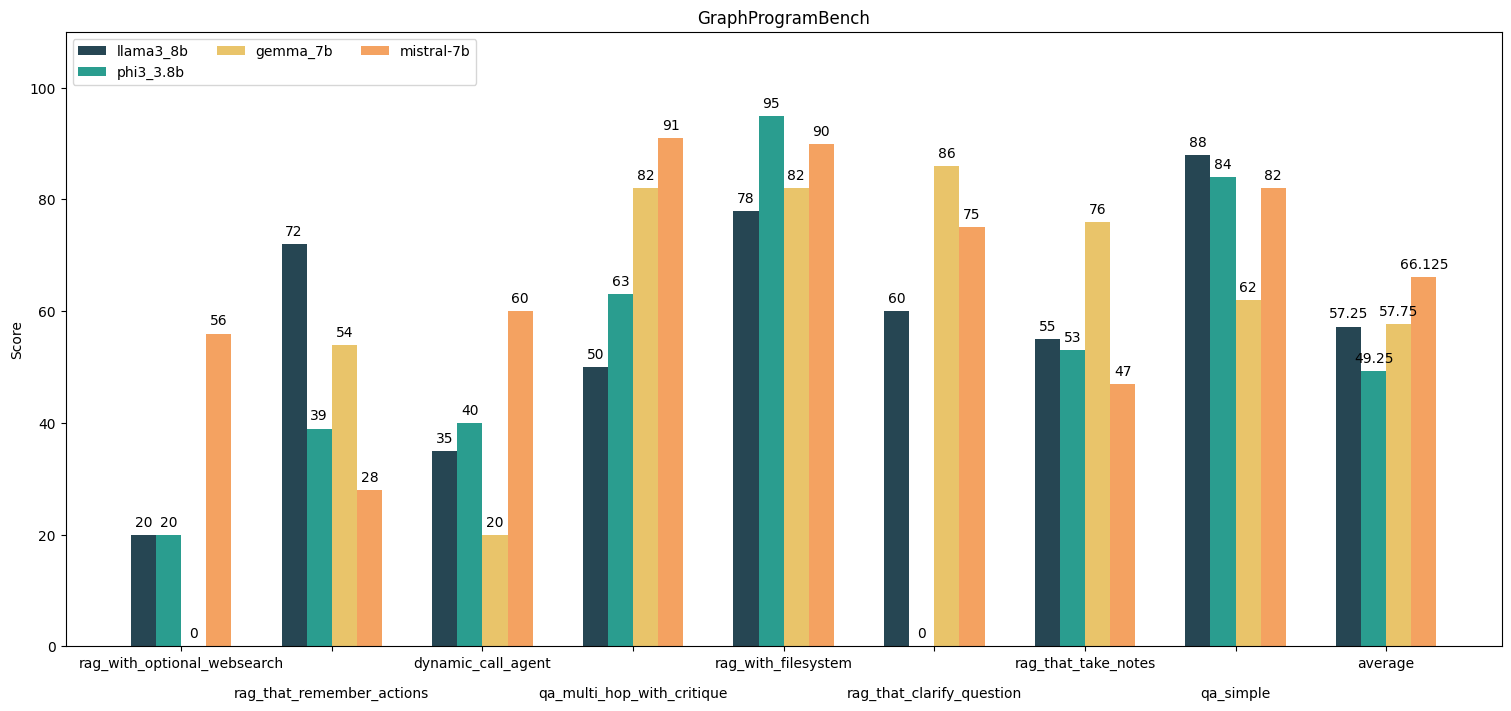

In [13]:
def showBenchmarkResults(results: pd.DataFrame):
    gap = 2
    x = np.arange(len(results.columns))
    width = 1/(len(results)+gap)
    fig, ax = plt.subplots(layout="constrained", figsize=(15, 7))
    colors = color_palette(len(results))

    for multiplier, (exp_name, (_, exp_data)) in enumerate(zip(LLM_models, results.iterrows())):
        offset = width * multiplier
        rects = ax.bar(x+offset, exp_data, width, label=exp_name, color=colors[multiplier])
        ax.bar_label(rects, padding=len(results))

    ax.set_ylabel("Score")
    ax.set_title("GraphProgramBench")
    ax.set_xticks(x + width*((len(results)-1)/2), results.columns)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 110)
    locs, labels = plt.xticks()
    for i, label in enumerate(labels):
        if i % 2 == 1:
            label.set_y(label.get_position()[1] - 0.05)

    #plt.xticks(rotation=-15)
    #plt.tight_layout()
    plt.show()

showBenchmarkResults(results)

The results show that overall Mistral leverages best the DSL to carry out the tasks it’s been given. However it doesn’t consistently outperform the other models on every task. In fact, it is the worst performer on two of the tasks that require I/O with the filesystem.

Llama3, gemma and phi3 perform very low on optional websearch rag, suggesting that decision making was maybe not figured relevantly, thus making the LLM answer with outdated knowledge, leading to incorrect answers.

On filesystem rag, better intern representation of what a filesystem is

# Adding a new model assessment to benchmark comparison

In [14]:
newModelToEvaluate = "gemma"
scores = evaluate_model(newModelToEvaluate, examples, embeddings)

scores.append(np.mean(scores))
results.loc[newModelToEvaluate] = scores

EXAMPLE  rag_with_optional_websearch
 --- Step 0 ---
Call Program: main
Program Purpose: What is the tallest mountain in the world?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES
 --- Step 2 ---
Action Purpose: Perform a duckduckgo search
Action: {
  "search_query": "tallest mountain<|end|><|assistant|> Objective: Identify the tallest mountain on Earth.",
  "results": [
    {
      "title": "Is Mount Everest really the tallest mountain on Earth?",
      "href": "https://www.livescience.com/tallest-mountain-on-earth",
      "body": "Researchers have measured Mount Everest many times over the past few decades, but the latest assessment, announced in November 2021, puts it at 29,031.69 feet (8,848.86 meters) above sea level ..."
    },
    {
      "title": "Highest Mountain in the World - Tallest Mountain - Geology.com",
 

2024-05-07 10:34:16,799 ERROR dspy.primitives.assertions: 2024-05-07T08:34:16.799139Z [error    ] AssertionError: Got ENVIRONMENTAL CONSERVATION.

Selected Label should be only ONE of the following label: MAYBE or UNKNOWN or YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:34:16,800 ERROR dspy.evaluate.evaluate: 2024-05-07T08:34:16.800200Z [error    ] Error for example in dev set: 		 Got ENVIRONMENTAL CONSERVATION.

Selected Label should be only ONE of the following label: MAYBE or UNKNOWN or YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  rag_that_remember_actions
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "blockchain technology explanation",
    "concept of blockchain<|end|><|assistant|> Objective: To provide a comprehensive understanding of blockchain technology."
  ],
  "past_actions": []
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: NO
 --- Step 3 ---
Action Purpose: Perform a duckduckgo search
Action: {
  "search_query": "define blockchain technology<|end|><|assistant|> Objective: To explain the concept of blockchain technology.",
  "results": [
    {
      "title": "Blockchain, explained | MIT Sloan",
      "href": "https://mitsloan.mit.edu/ideas-made-to-matter/blockchain-explained",
      "body": "Email Address. 

2024-05-07 10:35:32,463 ERROR dspy.evaluate.evaluate: 2024-05-07T08:35:32.463704Z [error    ] Error for example in dev set: 		 https://duckduckgo.com/ return None. params=None data={'q': "Define blockchain technology<|end|><|assistant|> Objective: To provide an overview of blockchain technology, including its definition and key features.\\n\\nContext:\\n- Blockchain technology allows a network of computers to agree on the true state of a distributed ledger at regular intervals. This ledger can contain various types of shared data.\\n- CoinDesk defines blockchain as a type of ledger technology that stores and records data, emphasizing its role in cryptocurrency transactions and potential applications beyond finance.\\n\\nPast Actions:\\n1. Searched for definitions and explanations of blockchain technology using MIT Sloan's resource and CoinDesk.\\n\\nDecision: The information gathered from the past actions is sufficient to provide an overview, but a more comprehensive search could inclu

 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "Date of French Revolution history events<|end|><|assistant|> Query: French Revolution timeline",
    "dates of major events in French Revolution<|end|><|assistant|> Query: French Revolution start date",
    "beginning of the French Revolution<|end|><|assistant|> Query: French Revolution years",
    "timeline of the French Revolution<|end|><|assistant|> Query: French Revolution historical dates",
    "chronology of the French Revolution<|end|><|assistant|> Query: When did the French Revolution begin?",
    "start date of the French Revolution<|end|><|assistant|> Query: French Revolution period",
    "timeframe of the French Revolution<|end|><|assistant|> Query: French Revolution occurrence year",
    "year when the French Revolution took place<|end|><|assistant|> Query: Historical date

2024-05-07 10:38:20,487 ERROR dspy.primitives.assertions: 2024-05-07T08:38:20.487633Z [error    ] AssertionError: Got BOTH<|END|><|ASSISTANT|> SELECTED LABEL: BOTH<|END|><|ASSISTANT|> OBJECTIVE: TO IDENTIFY KEY RESEARCH AREAS AND CHALLENGES IN NEURO-SYMBOLIC ARTIFICIAL INTELLIGENCE..

Selected Label should be only ONE of the following label: INSTRUCTION or QUESTION [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:38:20,488 ERROR dspy.evaluate.evaluate: 2024-05-07T08:38:20.488623Z [error    ] Error for example in dev set: 		 Got BOTH<|END|><|ASSISTANT|> SELECTED LABEL: BOTH<|END|><|ASSISTANT|> OBJECTIVE: TO IDENTIFY KEY RESEARCH AREAS AND CHALLENGES IN NEURO-SYMBOLIC ARTIFICIAL INTELLIGENCE..

Selected Label should be only ONE of the following label: INSTRUCTION or QUESTION [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Search for HybridAGI on internet
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: INSTRUCTION
 --- Step 2 ---
Call Program: fulfill_objective
Program Purpose: Fullfil the objective
 --- Step 3 ---
Action Purpose: Search for existing routine to fulfill the objective
Action: {
  "query": "HybridAGI search query",
  "routines": [
    {
      "routine": "filesystem_search: Perform a similarity based search on the filesystem"
    },
    {
      "routine": "internet_search: Search the answer to the given question on internet"
    },
    {
      "routine": "read_file_to_answer: Read the given document to answer the given question"
    }
  ]
}
 --- Step 4 ---
Decision Purpose: Check if the routine to fulfill the objective is in the previous search
Decision Question: Is the routine to fulfill the objective in the abov

2024-05-07 10:40:40,769 ERROR dspy.evaluate.evaluate: 2024-05-07T08:40:40.769076Z [error    ] Error for example in dev set: 		 ('Too many retries trying to get the correct output format. Try simplifying the requirements.', {'score': "ValueError('json output should start and end with { and }')"}) [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  qa_multi_hop_with_critique
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The use of artificial intelligence (AI) in performance evaluation and decision-making processes presents both risks and benefits for organizations. \n\nBenefits include:\n1. Improved efficiency: AI can automate repetitive tasks, allowing employees to focus on more complex responsibilities. This leads to increased productivity and faster processing of data.\n2. Enhanced accuracy: AI algorithms are capable of analyzing large volumes of data with high precision, reducing human error in performance evaluations and decision-making processes.\n3. Data-driven insights: By leveraging machine learning techniques, organizations can uncover hidden patterns and trends within their data th

2024-05-07 10:42:42,428 ERROR dspy.primitives.assertions: 2024-05-07T08:42:42.428372Z [error    ] AssertionError: Got THE PROVIDED RESPONSE ACCURATELY ADDRESSES THE IMPACTS OF ARTIFICIAL INTELLIGENCE (AI) ON JOB MOBILITY AND GEOGRAPHIC DISTRIBUTION OF JOBS BY HIGHLIGHTING BOTH POSITIVE ASPECTS SUCH AS THE CREATION OF NEW HIGH-SKILLED POSITIONS AND INCREASED REMOTE WORK OPPORTUNITIES, AS WELL AS POTENTIAL CHALLENGES LIKE AUTOMATION LEADING TO DISPLACEMENT. TO FURTHER ENHANCE ITS ACCURACY AND DEPTH:.

Selected Label should be only ONE of the following label: NO or YES [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:42:42,429 ERROR dspy.evaluate.evaluate: 2024-05-07T08:42:42.429517Z [error    ] Error for example in dev set: 		 Got THE PROVIDED RESPONSE ACCURATELY ADDRESSES THE IMPACTS OF ARTIFICIAL INTELLIGENCE (AI) ON JOB MOBILITY AND GEOGRAPHIC DISTRIBUTION OF JOBS BY HIGHLIGHTING BOTH POSITIVE ASPECTS SUCH AS THE CREATION OF NEW HIGH-SKILLED POSITIONS AND IN

 --- Step 0 ---
Call Program: main
Program Purpose: What are the negative implications of AI for the gig economy and freelance work?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The negative implications of AI on the gig economy and freelance work include job displacement as routine tasks are automated; reduced income opportunities due to increased competition from AI-powered platforms; skill obsolescence, where workers may find their skills outdated in an evolving technological landscape; and algorithmic decision-making that could lead to biased hiring processes or unfair pricing. Additionally, the widening economic disparity between those who can adapt to AI advancements and those who cannot might exacerbate existing social and economic challenges within these sectors.<|end|><|assistant|> Objective: Assess how artificial intelligence (AI) could negatively affect job security, income stability, skill development, and fair competition in the gi

2024-05-07 10:43:12,643 ERROR dspy.primitives.assertions: 2024-05-07T08:43:12.643746Z [error    ] AssertionError: Got 1. INCREASED PRODUCTIVITY THROUGH AUTOMATION.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:43:12,644 ERROR dspy.evaluate.evaluate: 2024-05-07T08:43:12.644846Z [error    ] Error for example in dev set: 		 Got 1. INCREASED PRODUCTIVITY THROUGH AUTOMATION.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What are some potential industries or professions that could be significantly affected by AI in the coming years? list 5 of them
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "1. Healthcare - AI can revolutionize diagnostics, patient care, and medical research by improving accuracy in disease detection, personalized treatment plans, and drug discovery processes.\n2. Transportation & Logistics - Autonomous vehicles, smart logistics systems, and predictive maintenance will transform the transportation industry, affecting jobs related to driving, fleet management, and supply chain operations.\n3. Manufacturing - AI-powered automation, robotics, and machine learning can optimize production processes, improve quality control, and reshape roles in manufacturing plants.\n4. Finance & Banking - AI will enhance fraud detection, risk assessment, algorithmic trading, personalized financial advice, and cust

2024-05-07 10:44:30,453 ERROR dspy.primitives.assertions: 2024-05-07T08:44:30.453314Z [error    ] AssertionError: Got 1. ADVANCED MACHINE LEARNING ALGORITHMS FOR PREDICTIVE ANALYTICS.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:44:30,454 ERROR dspy.evaluate.evaluate: 2024-05-07T08:44:30.454388Z [error    ] Error for example in dev set: 		 Got 1. ADVANCED MACHINE LEARNING ALGORITHMS FOR PREDICTIVE ANALYTICS.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: How can individuals prepare themselves for a future where AI plays a more prominent role in the workforce?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "To prepare for a future where AI plays an increasingly prominent role in the workforce, individuals should follow these steps:\n\n1. Understand AI and its impact on various industries: Stay informed about current developments in artificial intelligence technology and how it is being applied across different sectors. This can be achieved by reading industry publications, attending webinars or conferences, and following thought leaders in the field of AI.\n\n2. Identify transferable skills and those at risk of automation: Assess your current skill set to determine which abilities are likely to remain valuable even as AI becomes more prevalent. Transferable skills such as critical thinking, creativity, problem-solving, communication, and collabora

2024-05-07 10:45:38,324 ERROR dspy.primitives.assertions: 2024-05-07T08:45:38.324281Z [error    ] AssertionError: Got AI ETHICS RESEARCHER.

Selected Label should be only ONE of the following label: NO or YES [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:45:38,325 ERROR dspy.evaluate.evaluate: 2024-05-07T08:45:38.325067Z [error    ] Error for example in dev set: 		 Got AI ETHICS RESEARCHER.

Selected Label should be only ONE of the following label: NO or YES [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  rag_with_filesystem
 --- Step 0 ---
Call Program: main
Program Purpose: How does SynaLinks promote responsible AI use?
 --- Step 1 ---
Action Purpose: Search to information to answer the objective's question
Action: {
  "search_query": "SynaLinks responsible AI practices",
  "passages": []
}
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "SynaLinks promotes responsible AI use through various initiatives and programs that focus on ethical considerations, transparency, accountability, and inclusivity. Some of their key efforts include:\n\n1. Developing guidelines for responsible AI: SynaLinks has created a set of best practices and principles to guide the development and deployment of AI systems in an ethical manner. These guidelines emphasize transparency, fairness, privacy, security, and human-centric design.\n2. Collaborating with industry partners: The company works closely with other organizations, researchers, and policymakers to prom

2024-05-07 10:48:35,136 ERROR dspy.primitives.assertions: 2024-05-07T08:48:35.136250Z [error    ] AssertionError: Got "ENHANCING PERSONAL HYGIENE THROUGH EFFECTIVE HANDWASHING TECHNIQUES".

Selected Label should be only ONE of the following label: NO or YES or MAYBE [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:48:35,137 ERROR dspy.evaluate.evaluate: 2024-05-07T08:48:35.137292Z [error    ] Error for example in dev set: 		 Got "ENHANCING PERSONAL HYGIENE THROUGH EFFECTIVE HANDWASHING TECHNIQUES".

Selected Label should be only ONE of the following label: NO or YES or MAYBE [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Call Program: clarify_objective
Program Purpose: Clarify the objective if needed
 --- Step 2 ---
Decision Purpose: Check if the objective is unclear
Decision Question: Is the objective still unclear?
Decision: NO
 --- Step 3 ---
End Program: clarify_objective
 --- Step 4 ---
Action Purpose: Answer the objective's question
Action: {
  "message": "The French Revolution started in 1789, marking a significant period of social and political upheaval in France's history.<|end|><|assistant|> Message: Hello! The French Revolution occurred from 1789 to 1799, beginning with the storming of the Bastille on July 14th, 1789. This event marked the start of a decade-long period that saw major changes in France's political landscape and had lasting impacts on European history.<|end|><|assistant|> Message: Greetings! The French Revolution took place from 1789 to 1799. It was a pivotal moment in his

2024-05-07 10:50:33,247 ERROR dspy.primitives.assertions: 2024-05-07T08:50:33.247707Z [error    ] AssertionError: Got TITLE: VERIFY LATEST USER INTERFACE UPDATE MAINTAINS FUNCTIONALITY & ENHANCES DESIGN.

Selected Label should be only ONE of the following label: YES or MAYBE or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:50:33,248 ERROR dspy.evaluate.evaluate: 2024-05-07T08:50:33.248364Z [error    ] Error for example in dev set: 		 Got TITLE: VERIFY LATEST USER INTERFACE UPDATE MAINTAINS FUNCTIONALITY & ENHANCES DESIGN.

Selected Label should be only ONE of the following label: YES or MAYBE or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  rag_that_take_notes
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": "blockchain basics<|end|><|assistant|> Objective: Understand and explain blockchain technology.",
  "passages": [
    {
      "long_text": "Of course! Here is the content for the file `blockchain_concept.txt`:\n\nBlockchain is a distributed database that stores data in blocks linked by cryptography. It is decentralized, transparent, and tamper-proof, and can be used for various industries such as recording transactions and tracking assets in a business network.",
      "metadata": {
        "filename": "/home/user/blockchain_concept.txt"
      }
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- Step 3 ---
Ac

TypeError: can only concatenate str (not "int") to str

**Showing new results**

In [ ]:
showBenchmarkResults(results)